# Electrostatics of a Charge Coupled Device

A pedagogical introduction to the electrostatics of astronomical CCD sensors and buried channels.  We only consider the 1D problem here, which corresponds to finding the potential as a function of depth in the center of a large pixel.
See [this repo](https://github.com/craiglagegit/Poisson_CCD22) for the full 3D numerical calculation.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.sparse
import scipy.sparse.linalg

In [3]:
import astropy.units as u
import astropy.constants

## Poisson Equation for Semiconductors

### Poisson Equation in an Inhomogeneous Medium

The Poisson equation for electrostatics in a vacuum is:
$$
    \epsilon_0 \nabla^2 \phi(x) = \rho(x) \; ,
$$
where $\phi$ is the electric potential [Volts], $\rho$ is the charge density [Coulombs/cm$^3$], and the constant
$$
\epsilon_0 \simeq 8.85 \times 10^{-14} \;\text{F/cm}
$$
is the [permittivity](https://en.wikipedia.org/wiki/Permittivity) of free space [Farads/cm]. Since a Farad equals a Coulomb/Volt (via $Q = CV$), the units of both sides are [Volts/cm$^2$].  A related quantity is the electric field vector:
$$
\vec{E}(x) = \nabla \phi(x)
$$
with units [Volts/cm].  Note that none of the quantities above are written as functions of time since the Poisson equation describes electrostatic equilibrium.

A useful semiconductor has regions with different values of the permittivity so we need a generalized Poisson equation with $\epsilon_0 \rightarrow \epsilon(x)$, which is:
$$
    \nabla\cdot (\epsilon(x)\nabla\phi(x)) =
    \nabla\epsilon(x)\cdot\nabla\phi(x) + \epsilon(x) \nabla^2\phi(x) =
    \rho(x) \; .
$$
In a region where $\epsilon(x)$ is constant, this reduces to the usual Poisson equation:
$$
\epsilon(x) \nabla^2 \phi(x) = \rho(x) \; .
$$
Also, a discontinuity in $\epsilon(x)$ leads to a discontinuity in $\vec{E}(x)$ but the potential $\phi(x)$ and displacement field
$$
\vec{D}(x) \equiv \epsilon(x)\nabla\phi(x)
$$
are still continuous.

### Material Properties

The permittivity of silicon is usually assumed to be independent of doping (although see [here](http://www.doiserbia.nb.rs/img/doi/1451-4869/2004/1451-48690402237R.pdf)):
$$
\epsilon_{Si} = 11.68 \epsilon_0 \; .
$$
The other important material in a practical semiconductor is insulator, e.g. silicon dioxide with:
$$
\epsilon_{SiO2} = 3.9 \epsilon_0 \; .
$$

### Charge Density

The general form of the charge density in a semiconductor is (see eqn. 2.1 [here](http://www-tcad.stanford.edu/tcad/reports/piscesII.pdf)):
$$
\rho = -q (p - n + N_D - N_A) \; ,
$$
where $q$ is the electron charge, $p$ and $n$ are the concentrations [#/cm$^3$] of free hole and electron carriers, and $N_D$ and $N_A$ are the concentrations of fixed donor and acceptor ions.  The physical picture associated with these terms is that silicon is intrinsically electrically neutral:
$$
n(x) = N_D(x) \quad , \quad p(x) = N_A(x) \; ,
$$
The size of $n=N_D$ and $p=N_A$ depends on the doping and temperature $T$: undoped silicon has
$$
n = p = n_i(T) \; ,
$$
while doped silicon has different $n$ and $p$ but still conserves their product:
$$
n \cdot p = n_i(T)^2 \; .
$$
Therefore, a strongly n-doped region has $n \gg p$ which we approximate by setting $p = N_A = 0$, and similarly for a p-doped region.

An applied voltage creates an electric field that effectively sweeps away all of the free electrons and holes, $n(x) = p(x) \simeq 0$, leaving behind the fixed donor (+) and acceptor (-) ions. This leads to the depletion approximation for a doped region where an electric field is present. Specifically, in n-doped silicon we approximate:
$$
\rho(x) = -q N_D(x) = -q \rho_n(x)
$$
and in p-doped silicon:
$$
\rho(x) = +q N_A(x) = +q \rho_p(x)
$$
where $\rho_n$ and $\rho_p$ are the doping concentrations in [#/cm$^3$].  Since doping in a surface layer is usually specified in [#/cm$^2$], it has to be first converted to a concentration by dividing by the layer thickness.

### Doped Silicon

Define the emperical intrinsic concentration formula given [here](http://dx.doi.org/10.1063/1.354551):

In [4]:
def ni(T):
    return 5.29e19 * (T / 300) ** 2.54 * np.exp(-6726. / T)

Plot the intrinsic carrier concentration vs temperature covering the range from liquid nitrogen (63K - 77.2K) up to room temperature $\simeq$300K.  The `CCDTemperature` parameter in `data/run1/bf.cfg` is set to 173K.

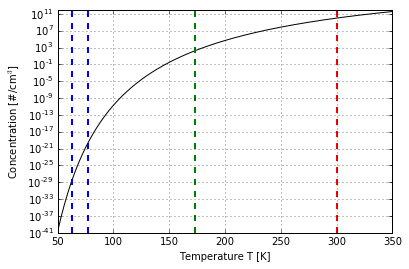

In [5]:
def plot_ni_vs_T(Tmin=50., Tmax=350.):
    T = np.linspace(Tmin, Tmax, 200)
    niT = ni(T)
    plt.plot(T, niT, 'k-')
    plt.yscale('log')
    plt.grid()
    plt.xlabel('Temperature T [K]')
    plt.ylabel('Concentration [#/cm$^3$]')
    plt.axvline(300., ls='--', lw=2, c='r')
    plt.axvline(63.0, ls='--', lw=2, c='b')
    plt.axvline(77.2, ls='--', lw=2, c='b')
    plt.axvline(173., ls='--', lw=2, c='g')

plot_ni_vs_T()

The concentrations in the `data/run1/bf.cfg` config file are summarized in the table below:

Name               | #/cm3    | #/cm2   | t [um]
-------------------|----------|---------|--------
BackgroundDoping   | -1.0e12  |         | 100.0
ChannelStopDoping  | -0.5e16  | -2.0e12 | 2.0
ChannelDoping      | +0.8e16  | +0.8e12 | 1.0

Note that these values have a sign that indicates whether they represent n (< 0) or p (> 0).

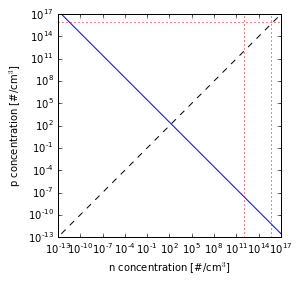

In [6]:
def plot_doping(T=173.0, cmax=1e17):
    niT = ni(T)
    cmin = niT ** 2 / cmax
    n = np.logspace(np.log10(cmin), np.log10(cmax), 50)
    p = niT ** 2 / n
    plt.plot(n, p)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().set_aspect(1.0)
    plt.xlabel('n concentration [#/cm$^3$]')
    plt.ylabel('p concentration [#/cm$^3$]')
    plt.plot([cmin, cmax], [cmin, cmax], 'k--')
    
    plt.axvline(1e12, ls=':', c='r')
    plt.axvline(0.5e16, ls=':', c='r')
    plt.axhline(0.8e16, ls=':', c='r')
    
plot_doping()

## 1D Solution

In 1D, the Poisson equation above reduces to:
$$
 \epsilon'(x) \phi'(x) + \epsilon(x) \phi''(x) = \rho(x) \; .
$$
We also need to specify the domain, $0 \le x \le x_{\text{max}}$, and its boundary conditions, which we take to be:
$$
    \phi(0) = V_g \quad , \quad \phi(x_{\text{max}}) = V_s \; ,
$$
where $V_g$ and $V_s$ are the externally imposed gate and substrate voltages.

### Analytic Solution

Appendix A of [this paper](http://dx.doi.org/10.1109/TED.2002.806476) solves the Poisson equation for a piecewise constant $\epsilon(x)$ and $\rho(x)$ that represents an three layer device: oxide + p(NA) + n--(ND).  The paper is missing an equation for $V_J$ but it can be determined from other equations:
$$
V_J = V_G - V_{FB} - E_{SiO2} d - E_J y_J - V_p' \; .
$$
Also note that the paper incorrectly states that the solution exhibits continuity of the electric field at $y = 0$: it is the displacement field that is continuous.

In [7]:
def analytic_solve(oxide_thickness, silicon_thickness, channel_depth, channel_doping, substrate_doping,
                   gate_voltage, substrate_bias, n_grid=2000):
    """Solve the 1D Poisson equation for a three-layer CCD with piecewise constant doping.
    
    The channel doping will be converted to the number density channel_doping / channel_depth.
    
    The channel and substrate doping values should have opposite signs.  A negative (positive) value
    indicates an n-doped (p-doped) region.
    
    All inputs should be specified with units.
    """
    # Prepare constants.
    q = astropy.constants.e.to(u.C) # explicit conversion required to resolve EMU / ESU ambiguity
    eps_SiO2 = 3.9 * astropy.constants.eps0
    eps_Si = 11.68 * astropy.constants.eps0
    d, y_J, y_N = oxide_thickness, channel_depth, silicon_thickness - channel_depth
    N_A, N_D = channel_doping / channel_depth, -substrate_doping
    V_G, V_sub = gate_voltage, substrate_bias
    V_FB = 0. * u.V
    
    # Evaluate (A13)-(A15)
    V_SiO2_p = q * N_A * y_J * d / eps_SiO2
    V_p_p = q * N_A / (2 * eps_Si) * y_J ** 2
    V_n_p = q * N_D / (2 * eps_Si) * y_N ** 2
    
    # Evaluate (A12)
    E_J = (V_G - V_FB - V_SiO2_p - V_p_p - V_n_p - V_sub) / (y_N + y_J + (eps_Si / eps_SiO2) * d)
    
    # Evaluate (A16)-(A18) using formula above.
    y_min = y_J + eps_Si / (q * N_A) * E_J
    E_SiO2 = q * N_A * y_min / eps_SiO2
    V_J = V_G - V_FB - E_SiO2 * d - E_J * y_J - V_p_p
    V_min = V_J - q * N_A / (2 * eps_Si) * (y_J - y_min) ** 2
    
    # Initialize the solution grid in microns.
    y = np.linspace(-d.to(u.um).value, (y_J + y_N).to(u.um).value, n_grid) * u.um
    V = np.empty_like(y.value) * u.V
    E = np.empty_like(y.value) * u.V / u.um
    
    # Define the 3 regions of the solution.
    R1 = y < 0
    R2 = (y >= 0) & (y < y_J)
    R3 = y >= y_J
    
    # Evaluate (A4)-(A6) in Volts.
    V[R1] = V_G - V_FB - E_SiO2 * (y[R1] + d)
    V[R2] = V_min + q * N_A / (2 * eps_Si) * (y[R2] - y_min) ** 2
    V[R3] = V_J - q * N_D / (2 * eps_Si) * (y[R3] - y_J) ** 2 - E_J * (y[R3] - y_J)
    
    # Evaluate (A7)-(A9)
    E[R1] = E_SiO2
    E[R2] = -q * N_A / eps_Si * (y[R2] - y_min)
    E[R3] = q * N_D / eps_Si * (y[R3] - y_J) + E_J

    return y, V, E

In [8]:
def plot_1d(y, V, E, y_zoom = 5 * u.um, y_layers=[], save=None):

    fig, (lhs, rhs) = plt.subplots(1, 2, figsize=(8, 4))
    
    zoom = (y < y_zoom)
    lhs.plot(y[zoom].to(u.um), V[zoom].to(u.V), lw=2, c='b')
    lhs.set_xlabel('Depth [$\mu$m]')
    lhs.set_ylabel('Potential [V]', color='b')
    lhs_r = lhs.twinx()
    lhs_r.scatter(y[zoom].to(u.um), E[zoom].to(u.V / u.um), lw=0, color='r', s=4.)
    lhs_r.set_ylabel('Electric Field [V/$\mu$m]', color='r')
    for y_layer in y_layers:
        lhs.axvline(y_layer.to(u.um).value, ls='--', c='k')
    lhs.set_xlim(y[0].to(u.um).value, y_zoom.to(u.um).value)

    rhs.plot(y.to(u.um), V.to(u.V), lw=2, c='b')
    rhs.set_xlabel('Depth [$\mu$m]')
    rhs.set_ylabel('Potential [V]', color='b')
    rhs_r = rhs.twinx()
    rhs_r.scatter(y.to(u.um), E.to(u.V / u.um), lw=0, color='r', s=1.)
    rhs_r.set_ylabel('Electric Field [V/$\mu$m]', color='r')
    rhs.set_xlim(y[0].to(u.um).value, y[-1].to(u.um).value)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

### Numerical Solution

If we discretize $\epsilon$, $\phi$ and $\rho$ on a uniform grid, $x_j = j\Delta$ with $j = 0,1,\ldots,N-1$, we can approximate the derivatives above using [second-order central finite differences](https://en.wikipedia.org/wiki/Finite_difference_coefficient) as:
$$
\left(\frac{\epsilon_{j+1} - \epsilon_{j-1}}{2\Delta}\right)
\left(\frac{\phi_{j+1} - \phi_{j-1}}{2\Delta}\right) +
\epsilon_j \left(\frac{\phi_{j+1} - 2\phi_j + \phi_{j-1}}{\Delta^2}\right) = \rho_j \; .
$$
These central-difference equations are only valid for interior points of our grid $1 \le j \le N-2$, so provide $N-2$ equations in the $N$ unknowns $\phi_j$.  However, they are supplemented by the boundary conditions, which provide the extra two equations needed for a solution:
$$
    \phi_0 = V_g \quad , \quad \phi_{N-1} = V_s \; .
$$

For the purposes of numerical solution, it is useful to write all the equations above as a single matrix equation:
$$
A \vec{\phi} = \vec{c} \; ,
$$
with:
$$
A = \begin{pmatrix}
1 & & & & \\
a_{1,-} & b_1 & a_{1,+} & & & & \\
& a_{2,-} & b_2 & a_{2,+} & & & \\
\\
& & \ddots & \ddots & \ddots & \\
\\
& & & a_{N-2,-} & b_{N-2} & a_{N-2,+} \\
& & & & & 1
\end{pmatrix} \quad , \quad
\vec{c} = \begin{pmatrix}
V_g \\ \rho_1 \\ \rho_2 \\ \\ \vdots \\ \\ \rho_{N-2} \\ V_s
\end{pmatrix} \; .
$$
The coefficient matrix is sparse since all elements are zero except for:
$$
a_{j,\pm} = \frac{\epsilon_j \pm (\epsilon_{j+1} - \epsilon_{j-1})/4}{\Delta^2} \quad , \quad
b_j = -\frac{2 \epsilon_j}{\Delta^2} \; .
$$
The formal solution to this approximate problem is now:
$$
\vec{\phi} = A^{-1} \vec{c}
$$
which can be solved efficiently using sparse-matrix algorithms.

In [9]:
def build_matrix(epsilon, delta):
    N = len(epsilon)
    A = np.zeros(shape=(N, N))
    delta_sq = delta ** 2
    A[0, 0] = 1.
    A[N-1, N - 1] = 1.
    for j in xrange(1, N-1):
        deps = (epsilon[j + 1] - epsilon[j - 1])
        A[j, j - 1] = (epsilon[j] - 0.25 * deps) / delta_sq
        A[j, j + 1] = (epsilon[j] + 0.25 * deps) / delta_sq
        A[j, j] = -2 * epsilon[j] / delta_sq
    return scipy.sparse.csr_matrix(A)

In [10]:
def build_cvec(rho, Vg, Vs):
    cvec = rho.copy()
    cvec[0] = Vg
    cvec[-1] = Vs
    return cvec

In [11]:
def numeric_solve(oxide_thickness, silicon_thickness, channel_depth, channel_doping, substrate_doping,
                  gate_voltage, substrate_bias, n_grid=2000, gaussian=False):
    """
    The numeric solver takes the same args as the analytic solver, plus a gaussian flag that selects
    a Gaussian doping profile for the channel when True.
    """
    # Initialize the solution grid in microns.
    y = np.linspace(-oxide_thickness.to(u.um).value, silicon_thickness.to(u.um).value, n_grid) * u.um
    delta = y[1] - y[0]

    # Define the 3 regions of the solution.
    R1 = y < 0
    R2 = (y >= 0) & (y < channel_depth)
    R3 = y >= channel_depth
    
    # Initialize the permittivity array.
    epsilon = np.ones_like(y.value) * astropy.constants.eps0
    epsilon[R1] *= 3.9
    epsilon[R2 | R3] *= 11.68
    
    # Initialize the charge density array in units of C.
    rho = np.empty_like(y.value) / u.cm ** 3
    rho[R1] = 0.
    rho[R2 | R3] = substrate_doping
    # Give the same total number of fixed ions either a Gaussian or boxcar distribution.
    if gaussian:
        rho[R2 | R3] += 2 * (channel_doping - substrate_doping * channel_depth) * np.exp(
            -0.5 * (y[R2 | R3] / channel_depth) ** 2) / np.sqrt(2 * np.pi) / channel_depth
    else:
        rho[R2] = channel_doping / channel_depth
    rho *= astropy.constants.e.to(u.C) # explicit conversion required to resolve EMU / ESU ambiguity

    # Initialize the approximate numerical problem.
    A = build_matrix(epsilon.to(u.F / u.um).value, delta.to(u.um).value)
    c = build_cvec(rho.to(u.C / u.um ** 3).value, gate_voltage.to(u.V).value, substrate_bias.to(u.V).value)
    
    # Solve the approximate numerical problem.
    V = scipy.sparse.linalg.spsolve(A, c) * u.V
    
    # Calculate the electric field as -V'(x)
    E = -np.gradient(V) / delta
    
    return y, V, E

### Compare Analytic and Numeric Solutions

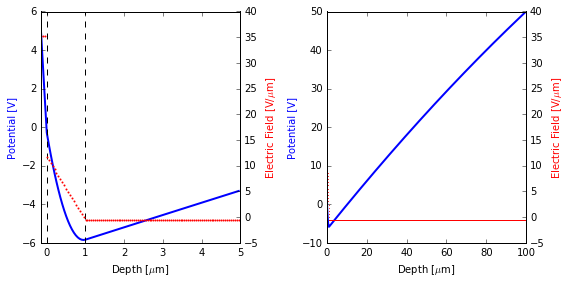

In [12]:
def test_analytic():
    y, V, E = analytic_solve(
        0.15 * u.um, 100.0 * u.um, 1.0 * u.um, 0.8e12 / u.cm ** 2, -1.0e12 / u.cm ** 3, 5 * u.V, 50 * u.V)
    plot_1d(y, V, E, y_layers=[0. * u.um, 1.0 * u.um])

test_analytic()

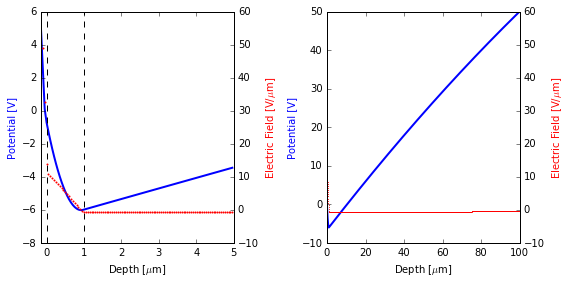

In [13]:
def test_numeric():
    y, V, E = numeric_solve(
        0.15 * u.um, 100.0 * u.um, 1.0 * u.um, 0.8e12 / u.cm ** 2, -1.0e12 / u.cm ** 3, 5 * u.V, 50 * u.V)
    plot_1d(y, V, E, y_layers=[0. * u.um, 1.0 * u.um])

test_numeric()

### Compare Boxcar and Gaussian Channel Profiles

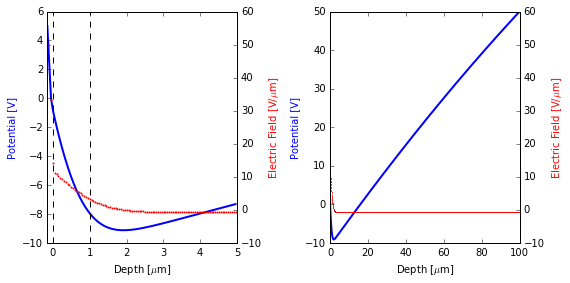

In [14]:
def test_gaussian(save=None):
    y, V, E = numeric_solve(
        0.15 * u.um, 100.0 * u.um, 1.0 * u.um, 0.8e12 / u.cm ** 2, -1.0e12 / u.cm ** 3, 5 * u.V, 50 * u.V,
        gaussian=True)
    plot_1d(y, V, E, y_layers=[0. * u.um, 1.0 * u.um])
    if save:
        plt.savefig(save)

test_gaussian('Poisson1D.png')